In [ ]:
# Copyright 2023 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

| | |
|----------|-------------|
| Author(s)   | Lei Pan |
| Last updated | 10/29/2023 |

# Iteratively Debugging with Code Chat

Codey models are text-to-code models from Google AI, trained on a massive code related dataset. You can generate code related responses for different scenarios such as writing functions, unit tests, debugging, explaining code etc. Here is [the overview](https://cloud.google.com/vertex-ai/docs/generative-ai/code/code-models-overview) of all the Codey APIs.

In this notebook, we will show you how to use code chat API to iteratively debug code issues by following the steps below.

- Step 1: Run code with errors
- Step 2: Debug with error message
- Step 3: Fix code based on error message
- Step 4: Test the first bug fix
- Step 5: New errors in the next block of code
- Step 6: Test the newly generated code
- Step 7: Another error in the next block of code
- Step 8: Test the lateste generated code
- Step 9: Best practices of preventing errors


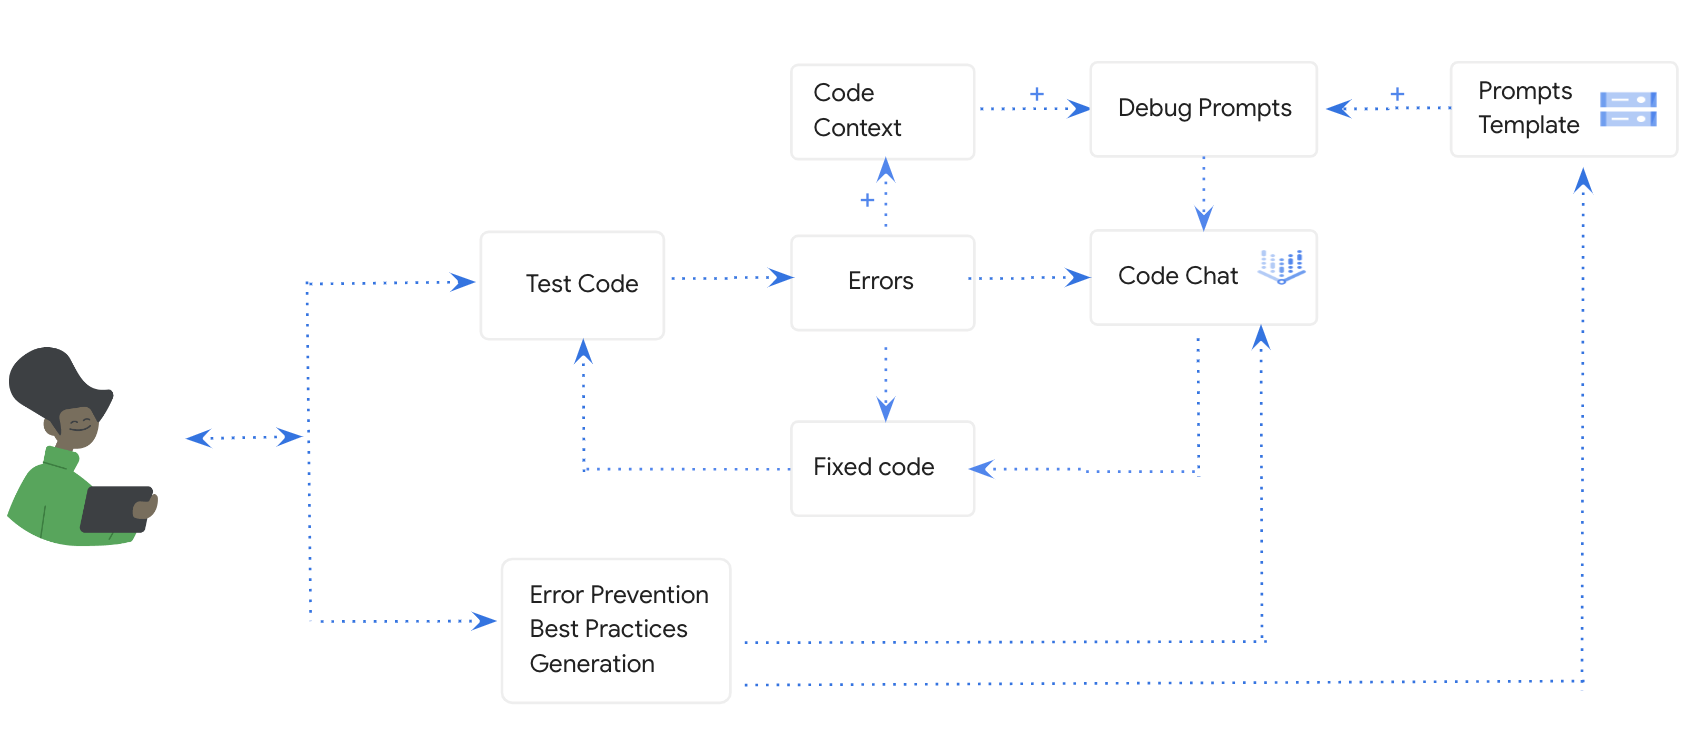

## Prep Work

If you don't have a GCP project set up and Vertex AI enabled, please follow [the doc](https://cloud.google.com/vertex-ai/docs/start/cloud-environment#set_up_a_project) to set them up before you proceed.



### Install Vertex AI SDK, Other Packages and Their Dependencies

Install the following packages required to execute this notebook.

In [ ]:
import sys
if 'google.colab' in sys.modules:
    ! pip install google-cloud-aiplatform
    ! pip install jsonlines
    from google.colab import auth as google_auth
    google_auth.authenticate_user()

In [ ]:
import sys
import json
import os
import vertexai
import pandas as pd
from typing import Dict, List, Optional, Tuple
from google.cloud import discoveryengine
from google.protobuf.json_format import MessageToDict

### Initialize Vertex AI

Please set VERTEX_API_PROJECT and VERTEX_API_LOCATION below with your project id and location for Vertex AI. This should be the project in which you enabled Vertex AI.

In [ ]:
import vertexai
from vertexai.language_models import CodeChatModel

VERTEX_API_PROJECT = '<project>'
VERTEX_API_LOCATION = '<location>'

vertexai.init(project=VERTEX_API_PROJECT, location=VERTEX_API_LOCATION)

### Initialize Code Chat Model

- You can specify the version of the Codey models you want to use. Here is [the list](https://cloud.google.com/vertex-ai/docs/generative-ai/learn/model-versioning)  of all the available models


- You can pass 3 parameters here: prompt, max size of token, and temperature.

In [ ]:
code_chat_model = CodeChatModel.from_pretrained("codechat-bison")
chat = code_chat_model.start_chat()

def send_message(message, max_token=1024):
    parameters = {
    "temperature": 0,
    "max_output_tokens": max_token
    }
    response = chat.send_message(message, **parameters)
    return response.text

### Load Prompt Templates from GCS
We used a prompt template in this example. For prompt templates that work, it would be useful to store them in a central location so that team can reuse it.

How to set up the prompt template:
- Step 1: Create a GCS bucket by following [this doc](https://cloud.google.com/storage/docs/creating-buckets)
- Step 2: For this example, you can upload [this csv](https://github.com/GoogleCloudPlatform/applied-ai-engineering-samples/blob/main/genai-on-vertex-ai/developer_productivity_with_genai/prompt_templates/Debugging-Prompt-Template.csv) to the bucket you created above.
- Step 3: Replace prompt template GCS URL below with the URL to your GCS bucket


In [ ]:
prompt_templates = pd.read_csv('<promt template GCS URL>', sep = ',')

## Step 1: Run Code with Errors

The code below is from a [Kaggle python debugging challenge](https://www.kaggle.com/code/clairebomkamp/pokemon-debugging-challenge/notebook).

To run the code below, you need to download [the pokemon-data.csv and move-data.csv](https://www.kaggle.com/datasets/n2cholas/competitive-pokemon-dataset?resource=download) from the kaggle project.

After you download them, please upload them to the same GCS bucket and replace your GCS bucket path below with the name of your GCS bucket.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast

plt.style.use('seaborn-ticks')
pokemon_data = pd.read_csv('gs://<your GCS bucket path>/pokemon-data.csv',
                           sep = ';', converters={'Types':ast.literal_eval, 'Abilities':ast.literal_eval, 'Moves':ast.literal_eval})
move_data = pd.read_csv('gs://d<your GCS bucket path>/move-data.csv', index_col = 0)
for var in ['Power', 'Accuracy']:
    move_data[var].replace('None', np.nan, inplace=True)
    move_data[var] = move_data[var].astype(float)

for contest in move_data.Contest.unique():
    data_subset = move_data[move_data.Move_Contest == contest]
    plt.scatter(data_subset.Power,
                data_subset.Accuracy, label = contest)
    plt.xlabel('Power')
    plt.ylabel('Accuracy')
plt.legend(loc = 'lower left', bbox_to_anchor = (1, 0))
plt.show()

## Step 2: Debug with Error Message

After you run the code above, you should see the error below.

In [ ]:
error_message = """
---------------------------------------------------------------------------
AttributeError                            Traceback (most recent call last)
<ipython-input-14-8c52ce2d8248> in <cell line: 16>()
     15
     16 for contest in move_data.Contest.unique():
---> 17     data_subset = move_data[move_data.Move_Contest == contest]
     18     plt.scatter(data_subset.Power,
     19                 data_subset.Accuracy, label = contest)

/usr/local/lib/python3.10/dist-packages/pandas/core/generic.py in __getattr__(self, name)
   5900         ):
   5901             return self[name]
-> 5902         return object.__getattribute__(self, name)
   5903
   5904     def __setattr__(self, name: str, value) -> None:

AttributeError: 'DataFrame' object has no attribute 'Move_Contest'
"""

Let's use the basic prompt to fix the error above. We print out the basic prompt that we send to the code chat model. You can see what it looks like in the output.

In [ ]:
basic_prompt = prompt_templates[prompt_templates['Type']=='Basic Debugging']['Prompt Template'][0]
print(basic_prompt)

You are great at debugging python code, please tell me how to fix the code based on the error message below: {error_message}


In [ ]:
response = send_message(basic_prompt.format(error_message=error_message))

In [ ]:
response_lines = response.split(".")
for line in response_lines:
    print(line)

 The error message indicates that the `move_data` DataFrame does not have a column named `Move_Contest`
 To fix the error, you can add the column to the DataFrame using the following code:

```python
move_data['Move_Contest'] = move_data['Contest']
apply(lambda x: x
split('_')[0])
```

This code uses the `apply()` method to add a new column to the DataFrame
 The `lambda` function extracts the first part of the `Contest` column value, which is the contest name


It suggested good fix for the error. But we want the code chat model to fix the code directly in the original code base rather than telling me what to fix. Let's move to the next step to see how we can do that.

## Step 3: Fix Code Based on Error Message

We changed the prompt to include more context (i.e.original code base) and more instructions (i.e. explain the fix). As you can see in the result below, it not only fixed the code directly in the old codebase, but it also explained the reason behind the fix suggestions.

In [ ]:
context = """
plt.style.use('seaborn-ticks')
pokemon_data = pd.read_csv('gs://<your GCS bucket path>/pokemon-data.csv',
                           sep = ';', converters={'Types':ast.literal_eval, 'Abilities':ast.literal_eval, 'Moves':ast.literal_eval})
move_data = pd.read_csv('gs://<your GCS bucket path>/move-data.csv', index_col = 0)
for var in ['Power', 'Accuracy']:
    move_data[var].replace('None', np.nan, inplace=True)
    move_data[var] = move_data[var].astype(float)

for contest in move_data.Contest.unique():
    data_subset = move_data[move_data.Move_Contest == contest]
    plt.scatter(data_subset.Power,
                data_subset.Accuracy, label = contest)
    plt.xlabel('Power')
    plt.ylabel('Accuracy')
plt.legend(loc = 'lower left', bbox_to_anchor = (1, 0))
plt.show()
"""

In [ ]:
debug_context_prompt = prompt_templates[prompt_templates['Type']=='Debugging with Context']['Prompt Template'][1]
print(debug_context_prompt)

Here is the original code: {context}. Please fix the original code based on the error message below: {error_message} and and explain what you fixed


In [ ]:
response = send_message(debug_context_prompt.format(context=context,error_message=error_message))

#response = send_message(prompt1)
def break_response_to_lines(response):
  response_lines = response.split("\n")
  for line in response_lines:
      print(line)
break_response_to_lines(response)

 The original code has the following error:

```
AttributeError: 'DataFrame' object has no attribute 'Move_Contest'
```

This error is because the `move_data` DataFrame does not have a column named `Move_Contest`. To fix this error, you can add the column to the DataFrame using the following code:

```python
move_data['Move_Contest'] = move_data['Contest'].apply(lambda x: x.split('_')[0])
```

This code uses the `apply()` method to add a new column to the DataFrame. The `lambda` function extracts the first part of the `Contest` column value, which is the contest name.

Once you have added the `Move_Contest` column to the DataFrame, you can then use it to filter the data and create the scatter plot. The following code shows the updated code:

```python
plt.style.use('seaborn-ticks')
pokemon_data = pd.read_csv('gs://demo_test_public_bucket/uj13/pokemon-data.csv',
                           sep = ';', converters={'Types':ast.literal_eval, 'Abilities':ast.literal_eval, 'Moves':ast.literal_

## Step 4: Test the First Bug Fix

Let's test out the bug fix by running the generated code below.

<ipython-input-15-b94a6781696a>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-ticks')


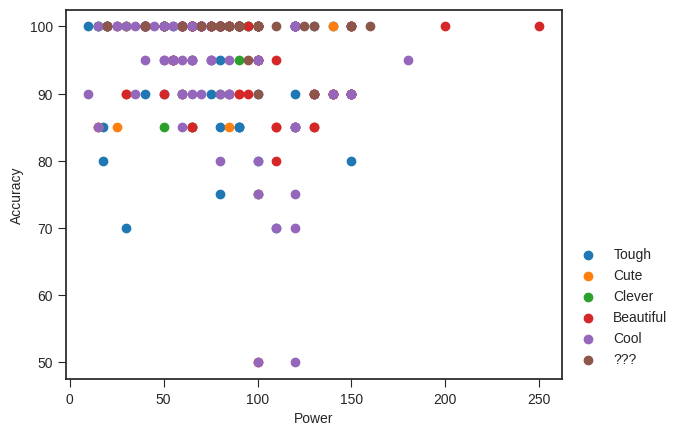

In [ ]:
plt.style.use('seaborn-ticks')
pokemon_data = pd.read_csv('gs://<your GCS bucket path>/pokemon-data.csv',
                           sep = ';', converters={'Types':ast.literal_eval, 'Abilities':ast.literal_eval, 'Moves':ast.literal_eval})
move_data = pd.read_csv('gs://<your GCS bucket path>/move-data.csv', index_col = 0)
for var in ['Power', 'Accuracy']:
    move_data[var].replace('None', np.nan, inplace=True)
    move_data[var] = move_data[var].astype(float)

for contest in move_data.Contest.unique():
    data_subset = move_data[move_data.Contest == contest]
    plt.scatter(data_subset.Power,
                data_subset.Accuracy, label = contest)
    plt.xlabel('Power')
    plt.ylabel('Accuracy')
plt.legend(loc = 'lower left', bbox_to_anchor = (1, 0))
plt.show()

Now, after we fix the old codebase, this functional block of code should be our new codebase context for the other debugging tasks in the following steps.

In [ ]:
context = """
plt.style.use('seaborn-ticks')
pokemon_data = pd.read_csv('gs://<your GCS bucket path>/pokemon-data.csv',
                           sep = ';', converters={'Types':ast.literal_eval, 'Abilities':ast.literal_eval, 'Moves':ast.literal_eval})
move_data = pd.read_csv('gs://<your GCS bucket path>/move-data.csv', index_col = 0)
for var in ['Power', 'Accuracy']:
    move_data[var].replace('None', np.nan, inplace=True)
    move_data[var] = move_data[var].astype(float)

for contest in move_data.Contest.unique():
    data_subset = move_data[move_data.Contest == contest]
    plt.scatter(data_subset.Power,
                data_subset.Accuracy, label = contest)
    plt.xlabel('Power')
    plt.ylabel('Accuracy')
plt.legend(loc = 'lower left', bbox_to_anchor = (1, 0))
plt.show()
"""

## Step 5: New Errors in the Next Block of Code

After we added this new block of code as it's shown in new_context, we got a new error as it's shown in the new_error_message.

We used the same prompt to generate the fix.

In [ ]:
new_context = """
for generation in move_data.Generation.unique():
    print(generation)
    data_subset = move_data[move_data.Generation == generation].dropna()
    subset_label = 'Generation ' + generation
    sns.kdeplot(data_subset.Power, label = subset_label, shade = True)
    plt.xlabel('Power')
    plt.ylabel('How many Pokemon')
plt.show()
"""
new_error_message = """
---------------------------------------------------------------------------
TypeError                                 Traceback (most recent call last)
<ipython-input-5-b8b08e95c8e1> in <module>()
      2     print(generation)
      3     data_subset = move_data[move_data.Generation == generation].dropna()
----> 4     subset_label = 'Generation ' + generation
      5     sns.kdeplot(data_subset.Power, label = subset_label, shade = True)
      6     plt.xlabel('Power')

TypeError: must be str, not numpy.int64
"""

In [ ]:
def new_error_context_send_message(context, new_context, new_error_message):
  new_context = context + new_context
  debug_new_context_prompt = prompt_templates[prompt_templates['Type']=='Debugging with Context Function']['Prompt Template'][2]

  return send_message(debug_new_context_prompt.format(new_context=new_context,new_error_message=new_error_message)), context+new_context

In [ ]:
response, context = new_error_context_send_message(context, new_context, new_error_message)
break_response_to_lines(response)

 The error is saying that the `generation` variable is a numpy.int64, but the `+` operator can only be used with strings. To fix the error, you can convert the `generation` variable to a string using the `str()` function.

Here is the fixed code:

```
plt.style.use('seaborn-ticks')
pokemon_data = pd.read_csv('gs://demo_test_public_bucket/uj13/pokemon-data.csv',
                           sep = ';', converters={'Types':ast.literal_eval, 'Abilities':ast.literal_eval, 'Moves':ast.literal_eval})
move_data = pd.read_csv('gs://demo_test_public_bucket/uj13/move-data.csv', index_col = 0)
for var in ['Power', 'Accuracy']:
    move_data[var].replace('None', np.nan, inplace=True)
    move_data[var] = move_data[var].astype(float)

for contest in move_data.Contest.unique():
    data_subset = move_data[move_data.Contest == contest]
    plt.scatter(data_subset.Power,
                data_subset.Accuracy, label = contest)
    plt.xlabel('Power')
    plt.ylabel('Accuracy')
plt.legend(loc = 'lower left'

## Step 6: Test the Newly Generated Code

We run the code below to test the fix. It worked.

<ipython-input-24-be7e292afcb2>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-ticks')


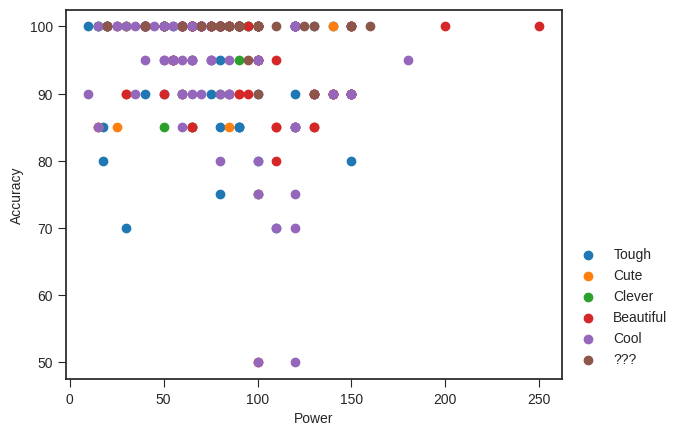

1
2
3


<ipython-input-24-be7e292afcb2>:23: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data_subset.Power, label = subset_label, shade = True)
<ipython-input-24-be7e292afcb2>:23: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data_subset.Power, label = subset_label, shade = True)
<ipython-input-24-be7e292afcb2>:23: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data_subset.Power, label = subset_label, shade = True)


4
5
6
7


<ipython-input-24-be7e292afcb2>:23: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data_subset.Power, label = subset_label, shade = True)
<ipython-input-24-be7e292afcb2>:23: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data_subset.Power, label = subset_label, shade = True)
<ipython-input-24-be7e292afcb2>:23: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data_subset.Power, label = subset_label, shade = True)
<ipython-input-24-be7e292afcb2>:23: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data_subset

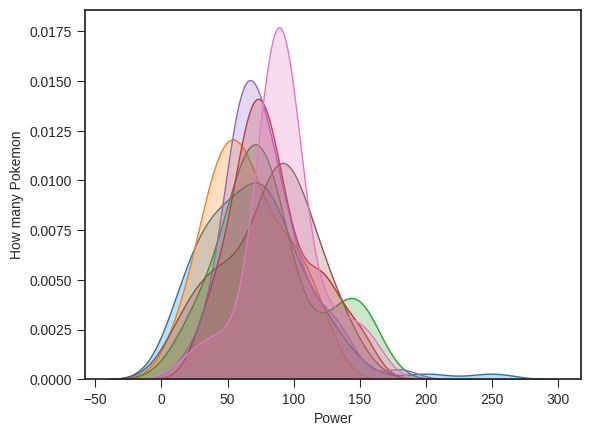

In [ ]:
 plt.style.use('seaborn-ticks')
pokemon_data = pd.read_csv('gs://<your GCS bucket path>/pokemon-data.csv',
                           sep = ';', converters={'Types':ast.literal_eval, 'Abilities':ast.literal_eval, 'Moves':ast.literal_eval})
move_data = pd.read_csv('gs://<your GCS bucket path>/move-data.csv', index_col = 0)
for var in ['Power', 'Accuracy']:
    move_data[var].replace('None', np.nan, inplace=True)
    move_data[var] = move_data[var].astype(float)

for contest in move_data.Contest.unique():
    data_subset = move_data[move_data.Contest == contest]
    plt.scatter(data_subset.Power,
                data_subset.Accuracy, label = contest)
    plt.xlabel('Power')
    plt.ylabel('Accuracy')
plt.legend(loc = 'lower left', bbox_to_anchor = (1, 0))
plt.show()

for generation in move_data.Generation.unique():
    print(generation)
    data_subset = move_data[move_data.Generation == generation].dropna()
    subset_label = 'Generation ' + str(generation)
    sns.kdeplot(data_subset.Power, label = subset_label, shade = True)
    plt.xlabel('Power')
    plt.ylabel('How many Pokemon')
plt.show()


Now, after we fix the old codebase, this functional block of code should be our new codebase context for the other debugging tasks in the following steps.

In [ ]:
context = """
plt.style.use('seaborn-ticks')
pokemon_data = pd.read_csv('gs://<your GCS bucket path>/pokemon-data.csv',
                           sep = ';', converters={'Types':ast.literal_eval, 'Abilities':ast.literal_eval, 'Moves':ast.literal_eval})
move_data = pd.read_csv('gs://<your GCS bucket path>/move-data.csv', index_col = 0)
for var in ['Power', 'Accuracy']:
    move_data[var].replace('None', np.nan, inplace=True)
    move_data[var] = move_data[var].astype(float)

for contest in move_data.Contest.unique():
    data_subset = move_data[move_data.Contest == contest]
    plt.scatter(data_subset.Power,
                data_subset.Accuracy, label = contest)
    plt.xlabel('Power')
    plt.ylabel('Accuracy')
plt.legend(loc = 'lower left', bbox_to_anchor = (1, 0))
plt.show()

for generation in move_data.Generation.unique():
    print(generation)
    data_subset = move_data[move_data.Generation == generation].dropna()
    subset_label = 'Generation ' + str(generation)
    sns.kdeplot(data_subset.Power, label = subset_label, shade = True)
    plt.xlabel('Power')
    plt.ylabel('How many Pokemon')
plt.show()
"""

## Step 7: Another Error in the Next Block of Code

After we added this new block of code as it's shown in new_context, we got a new error as it's shown in the new_error_message.

We used the same prompt to generate the fix to fix the last bug.

In [ ]:
new_context = """
plt.scatter(pokemon_data.Attack,
            pokemon_data['Special Attack'], color = pokemon_data.Defense, cmap = 'cool', alpha = 0.5)
plt.xlabel('Attack')
plt.ylabel('Special Attack')
plt.colorbar(label = 'Defense')
plt.show()
"""
new_error_message = """
---------------------------------------------------------------------------
KeyError                                  Traceback (most recent call last)
/opt/conda/lib/python3.6/site-packages/matplotlib/colors.py in to_rgba(c, alpha)
    173     try:
--> 174         rgba = _colors_full_map.cache[c, alpha]
    175     except (KeyError, TypeError):  # Not in cache, or unhashable.

KeyError: (75, None)

During handling of the above exception, another exception occurred:

ValueError                                Traceback (most recent call last)
/opt/conda/lib/python3.6/site-packages/matplotlib/axes/_axes.py in scatter(self, x, y, s, c, marker, cmap, norm, vmin, vmax, alpha, linewidths, verts, edgecolors, **kwargs)
   4142             try:
-> 4143                 mcolors.to_rgba_array(co)
   4144             except ValueError:

/opt/conda/lib/python3.6/site-packages/matplotlib/colors.py in to_rgba_array(c, alpha)
    274     for i, cc in enumerate(c):
--> 275         result[i] = to_rgba(cc, alpha)
    276     return result

/opt/conda/lib/python3.6/site-packages/matplotlib/colors.py in to_rgba(c, alpha)
    175     except (KeyError, TypeError):  # Not in cache, or unhashable.
--> 176         rgba = _to_rgba_no_colorcycle(c, alpha)
    177         try:

/opt/conda/lib/python3.6/site-packages/matplotlib/colors.py in _to_rgba_no_colorcycle(c, alpha)
    226         # Test dimensionality to reject single floats.
--> 227         raise ValueError("Invalid RGBA argument: {!r}".format(orig_c))
    228     # Return a tuple to prevent the cached value from being modified.

ValueError: Invalid RGBA argument: 75

During handling of the above exception, another exception occurred:

ValueError                                Traceback (most recent call last)
<ipython-input-6-dba81d5a88a8> in <module>()
      1 plt.scatter(pokemon_data.Attack,
----> 2             pokemon_data['Special Attack'], color = pokemon_data.Defense, cmap = 'cool', alpha = 0.5)
      3 plt.xlabel('Attack')
      4 plt.ylabel('Special Attack')
      5 plt.colorbar(label = 'Defense')

/opt/conda/lib/python3.6/site-packages/matplotlib/pyplot.py in scatter(x, y, s, c, marker, cmap, norm, vmin, vmax, alpha, linewidths, verts, edgecolors, data, **kwargs)
   2860         vmin=vmin, vmax=vmax, alpha=alpha, linewidths=linewidths,
   2861         verts=verts, edgecolors=edgecolors, **({"data": data} if data
-> 2862         is not None else {}), **kwargs)
   2863     sci(__ret)
   2864     return __ret

/opt/conda/lib/python3.6/site-packages/matplotlib/__init__.py in inner(ax, data, *args, **kwargs)
   1808                         "the Matplotlib list!)" % (label_namer, func.__name__),
   1809                         RuntimeWarning, stacklevel=2)
-> 1810             return func(ax, *args, **kwargs)
   1811
   1812         inner.__doc__ = _add_data_doc(inner.__doc__,

/opt/conda/lib/python3.6/site-packages/matplotlib/axes/_axes.py in scatter(self, x, y, s, c, marker, cmap, norm, vmin, vmax, alpha, linewidths, verts, edgecolors, **kwargs)
   4143                 mcolors.to_rgba_array(co)
   4144             except ValueError:
-> 4145                 raise ValueError("'color' kwarg must be an mpl color"
   4146                                  " spec or sequence of color specs.\n"
   4147                                  "For a sequence of values to be color-mapped,"

ValueError: 'color' kwarg must be an mpl color spec or sequence of color specs.
For a sequence of values to be color-mapped, use the 'c' argument instead.
"""

In [ ]:
response,context = new_error_context_send_message(context, new_context, new_error_message)
break_response_to_lines(response)

 The error is saying that the `color` argument in the `plt.scatter()` function must be an mpl color spec or sequence of color specs. In this case, the `color` argument is set to `pokemon_data.Defense`, which is not a valid color spec. To fix the error, you can change the `color` argument to a valid color spec, such as `"red"` or `"#ff0000"`.

Here is the fixed code:

```
plt.style.use('seaborn-ticks')
pokemon_data = pd.read_csv('gs://demo_test_public_bucket/uj13/pokemon-data.csv',
                           sep = ';', converters={'Types':ast.literal_eval, 'Abilities':ast.literal_eval, 'Moves':ast.literal_eval})
move_data = pd.read_csv('gs://demo_test_public_bucket/uj13/move-data.csv', index_col = 0)
for var in ['Power', 'Accuracy']:
    move_data[var].replace('None', np.nan, inplace=True)
    move_data[var] = move_data[var].astype(float)

for contest in move_data.Contest.unique():
    data_subset = move_data[move_data.Contest == contest]
    plt.scatter(data_subset.Power,
             

## Step 8: Test the Latest Generated Code

We tested the latest generated code. It fixed all bugs.

<ipython-input-28-0206cc9bbe58>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-ticks')


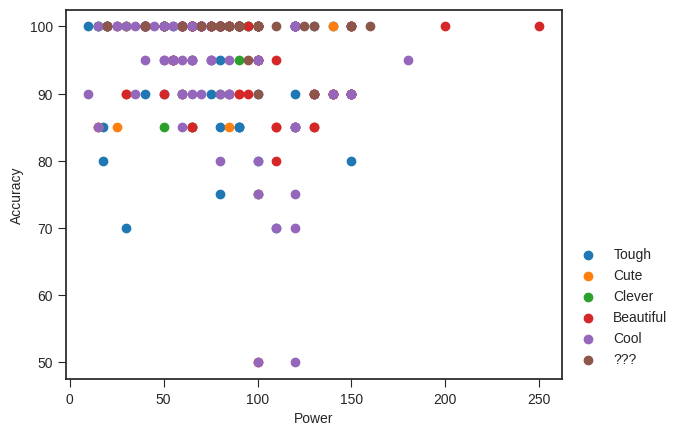

1
2
3
4
5
6
7


<ipython-input-28-0206cc9bbe58>:24: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data_subset.Power, label = subset_label, shade = True)
<ipython-input-28-0206cc9bbe58>:24: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data_subset.Power, label = subset_label, shade = True)
<ipython-input-28-0206cc9bbe58>:24: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data_subset.Power, label = subset_label, shade = True)
<ipython-input-28-0206cc9bbe58>:24: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data_subset

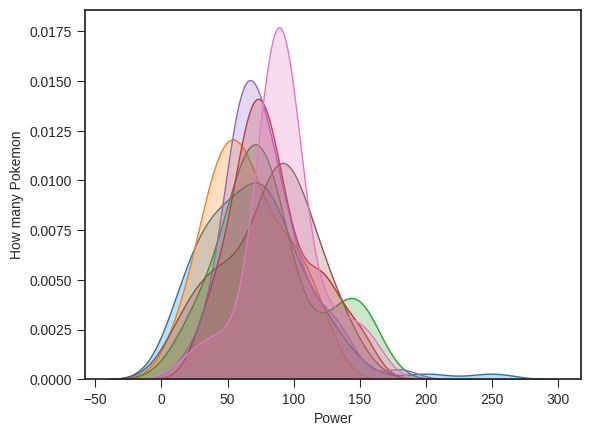

<ipython-input-28-0206cc9bbe58>:29: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(pokemon_data.Attack,


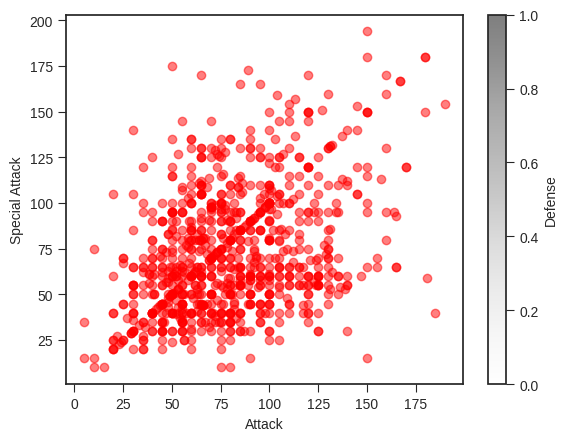

In [ ]:
plt.style.use('seaborn-ticks')
pokemon_data = pd.read_csv('gs://<your GCS bucket path>/pokemon-data.csv',
                           sep = ';', converters={'Types':ast.literal_eval, 'Abilities':ast.literal_eval, 'Moves':ast.literal_eval})
move_data = pd.read_csv('gs://d<your GCS bucket path>/move-data.csv', index_col = 0)
for var in ['Power', 'Accuracy']:
    move_data[var].replace('None', np.nan, inplace=True)
    move_data[var] = move_data[var].astype(float)

for contest in move_data.Contest.unique():
    data_subset = move_data[move_data.Contest == contest]
    plt.scatter(data_subset.Power,
                data_subset.Accuracy, label = contest)
    plt.xlabel('Power')
    plt.ylabel('Accuracy')
plt.legend(loc = 'lower left', bbox_to_anchor = (1, 0))
plt.show()

for generation in move_data.Generation.unique():
    print(generation)
    data_subset = move_data[move_data.Generation == generation].dropna()
    subset_label = 'Generation ' + str(generation)
    sns.kdeplot(data_subset.Power, label = subset_label, shade = True)
    plt.xlabel('Power')
    plt.ylabel('How many Pokemon')
plt.show()

plt.scatter(pokemon_data.Attack,
            pokemon_data['Special Attack'], color = 'red', cmap = 'cool', alpha = 0.5)
plt.xlabel('Attack')
plt.ylabel('Special Attack')
plt.colorbar(label = 'Defense')
plt.show()

##  Step 9: Best Practices of Preventing Errors

Last but not least, we want to ask code chat model what best practices we could learn from all the mistakes/bugs the model fixed above by using this prompt - *Based on the errors above, please tell me how to prevent similar errors in the future in this codebase*.

In [ ]:
best_practice_prompt = prompt_templates[prompt_templates['Type']=='Error Prevention']['Prompt Template'][3]
response = send_message(best_practice_prompt)

In [ ]:
response
response_lines = response.split("\n")
for line in response_lines:
    print(line)

 To prevent similar errors in the future, you can do the following:

* Use the `plt.scatter()` function's `c` argument instead of the `color` argument when you want to color-map a sequence of values.
* Make sure that the `color` argument of the `plt.scatter()` function is a matplotlib color spec or a sequence of color specs.
* Use the `to_rgba()` function to convert a color spec to an RGBA tuple.
* Use the `to_rgba_array()` function to convert a sequence of color specs to an RGBA array.
